In [2]:
!pip install boto3 pandas plotly requests pillow tabulate kaleido nbformat ipython

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import json
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import ast

from utils import get_df_for_benchmark, performance_score, shorten_gpu_name

In [3]:
benchmark_id = "benchmark-id-1"

# if data-1.csv exists, load it
try:
    print("Loading data from data-1.csv")
    df = pd.read_csv("./data-1.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
except FileNotFoundError:
    # otherwise, get the data from the API
    print("Cached CSV not found. Loading data from DynamoDB")
    df = get_df_for_benchmark(benchmark_id)
    df["gpu"] = df["gpu"].apply(shorten_gpu_name)
    df["performance_score"] = df["gpu"].apply(performance_score)
    df.to_csv("./data-1.csv", index=False)
except Exception as e:
    print("Error loading data from CSV.")
    print(e)



Loading data from data-1.csv


In [4]:

# in df.tags, replace nan with None, and eval the string
df["tags"] = df["tags"].fillna("None").apply(ast.literal_eval)
df["rating"] = df["rating"].fillna("None").apply(ast.literal_eval)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373808 entries, 0 to 373807
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   media              373808 non-null  object        
 1   inference_time     373808 non-null  int64         
 2   tags               372600 non-null  object        
 3   characters         372600 non-null  object        
 4   rating             372600 non-null  object        
 5   embeddings         372600 non-null  object        
 6   vCPU               373808 non-null  int64         
 7   MemGB              373808 non-null  float64       
 8   gpu                373808 non-null  object        
 9   timestamp          373808 non-null  datetime64[ns]
 10  detail             1208 non-null    object        
 11  performance_score  373808 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 34.2+ MB


In [6]:
df.head(5)

,media,inference_time,tags,characters,rating,embeddings,vCPU,MemGB,gpu,timestamp,detail,performance_score
0,https://salad-benchmark-public-assets.s3.amazo...,1159,"{'holding': 0.45994266867637634, 'food': 0.758...",{},"{'general': 0.8978943824768066, 'sensitive': 0...","[[0.41837188601493835, 0.22150367498397827, -0...",24,7.71,RTX 3060,2023-09-15 16:41:27.296,NaN,3060.1
1,https://salad-benchmark-public-assets.s3.amazo...,1126,"{'blurry': 0.7102534770965576, 'gradient': 0.4...",{},"{'general': 0.8896938562393188, 'sensitive': 0...","[[-0.3079083561897278, 0.20151205360889435, -0...",24,7.71,RTX 3060,2023-09-15 16:41:27.296,NaN,3060.1
2,https://salad-benchmark-public-assets.s3.amazo...,1211,"{'simple_background': 0.8454210758209229, 'whi...",{},"{'general': 0.9722062349319458, 'sensitive': 0...","[[0.08680236339569092, -0.4548403024673462, -0...",24,7.71,RTX 3060,2023-09-15 16:41:27.296,NaN,3060.1
3,https://salad-benchmark-public-assets.s3.amazo...,1115,"{'solo': 0.966446042060852, 'blue_eyes': 0.821...",{},"{'general': 0.7698329091072083, 'sensitive': 0...","[[-0.36566460132598877, 0.10593843460083008, -...",24,7.71,RTX 3060,2023-09-15 16:41:27.296,NaN,3060.1
4,https://salad-benchmark-public-assets.s3.amazo...,1084,"{'simple_background': 0.938351035118103, 'flow...",{},"{'general': 0.9667389392852783, 'sensitive': 0...","[[-0.1808740198612213, 0.2722926139831543, 0.1...",24,7.71,RTX 3060,2023-09-15 16:41:27.296,NaN,3060.1


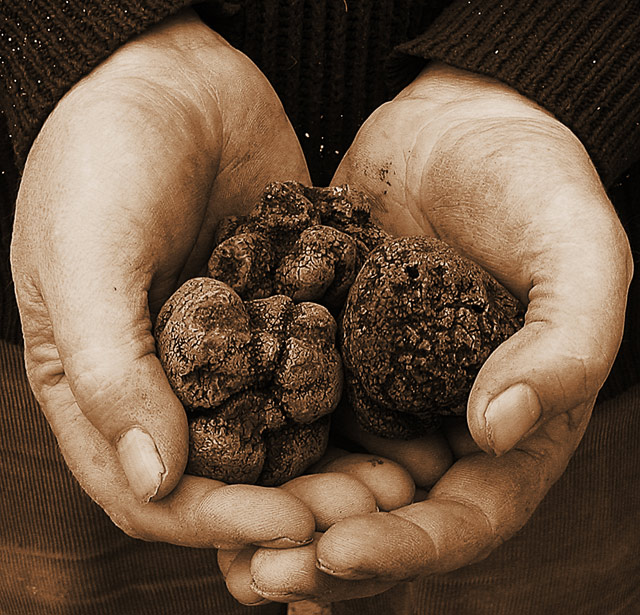

In [7]:
# load the image from the file path specified in the dataframe
image = load_image(df.loc[0, 'media'])
image


In [8]:
import pprint

pretty = pprint.PrettyPrinter(indent=4)

# pretty print the tags and rating in the console
pretty.pprint(df.loc[0, "tags"])
pretty.pprint(df.loc[0, "rating"])



{   '1other': 0.5011857151985168,
    'ambiguous_gender': 0.38422226905822754,
    'close-up': 0.3592078685760498,
    'food': 0.7583510279655457,
    'food_focus': 0.4451887905597687,
    'holding': 0.45994266867637634,
    'no_humans': 0.41321325302124023,
    'realistic': 0.9306589365005493}
{   'explicit': 0.0008636713027954102,
    'general': 0.8978943824768066,
    'questionable': 0.003336608409881592,
    'sensitive': 0.11550512909889221}


In [9]:
# Create a filtered df w/ only the columns we want to display
df_filtered = df[["media", "tags", "rating"]].copy()

# Render media as markdown image links.
df_filtered["media"] = df_filtered["media"].apply(lambda x: f"![]({x})")

def sort_dict_and_htmlify(d):
  if d is None:
    return None
  # sort the dict by value descending
  d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
  # convert to html list
  return dict_to_html_list(d)

df_filtered["tags"] = df_filtered["tags"].apply(sort_dict_and_htmlify)
df_filtered["rating"] = df_filtered["rating"].apply(sort_dict_and_htmlify)

# Write to markdown files, 100 rows per file, ./markdown/00000.md, ./markdown/00001.md, etc for each page
for n, i in enumerate(range(0, len(df_filtered.head(1000)), 100)):
  df_filtered.iloc[i:i+100].to_markdown(f"./markdown/{str(n).zfill(5)}.md", index=False)
  

In [42]:
# group by gpu, and get the distribution of inference time for each gpu
df_grouped = df.groupby("gpu")["inference_time"]

q1 = df_grouped.quantile(0.25)
q2 = df_grouped.quantile(0.5)
q3 = df_grouped.quantile(0.75)

iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

mean = df_grouped.mean()

# filter out outliers
max_vals = df_grouped.apply(lambda x: x[x < upper[x.name]].max())
min_vals = df_grouped.apply(lambda x: x[x > lower[x.name]].min())

stats_df = pd.DataFrame({
    "min": min_vals,
    "q1": q1,
    "q2": q2,
    "q3": q3,
    "max": max_vals,
    "mean": mean,
}).reset_index()
stats_df

,gpu,min,q1,q2,q3,max,mean
0,GTX 1050 Ti & Quadro P400,1878,2137.00,2234.0,2311.50,2569,2224.062205
1,GTX 1060,1032,1286.00,1388.0,1456.00,1709,1361.061840
2,GTX 1650,607,964.00,1077.0,1575.00,2491,1319.441784
3,GTX 1650 Ti,1533,1788.00,1872.0,1973.00,2206,1878.256560
4,GTX 1660,253,1191.00,1476.0,1945.00,3075,1640.140613
5,GTX 1660 Ti,1244,1601.00,1701.5,1840.00,2198,1817.885411
6,RTX 3060,305,949.00,1155.0,1432.00,2156,1342.951559
7,RTX 3060 Ti,743,1133.00,1457.0,1854.00,2935,1629.958508
8,RTX 3070,546,936.00,1336.0,1927.00,3412,1465.011331
9,RTX 3070 & GTX 1070,1455,1825.25,1929.5,2092.25,2487,1993.372054


In [50]:
intervals = ["min", "q1", "q2", "q3", "max"]

traces = []
for index, row in stats_df.iterrows():
  traces.append(go.Box(
    y=[row[i] for i in intervals],
    name=row["gpu"],
  ))

layout = go.Layout(
  title="Inference Time Distribution",
  xaxis_title="GPU",
  yaxis_title="Inference Time (ms)",
  height=800,
  width=1080)

fig = go.Figure(data=traces, layout=layout)
fig.show()
fig.write_image("./images/inf-time-by-gpu.png")

In [51]:
base_cost = 0.071
with open("./gpu-cost.json", "r") as f:
  gpu_cost = json.load(f)

stats_df["cost_per_hour"] = stats_df["gpu"].map(gpu_cost) + base_cost

ms_per_hour = 60 * 60 * 1000
for i in [*intervals, "mean"]:
  images_per_hour = ms_per_hour / stats_df[i]
  stats_df["images_per_dollar_" + i] = images_per_hour / stats_df["cost_per_hour"]

stats_df

,gpu,min,q1,q2,q3,max,mean,cost_per_hour,images_per_dollar_min,images_per_dollar_q1,images_per_dollar_q2,images_per_dollar_q3,images_per_dollar_max,images_per_dollar_mean
0,GTX 1050 Ti & Quadro P400,1878,2137.00,2234.0,2311.50,2569,2224.062205,0.091,21065.196784,18512.138306,17708.343581,17114.618023,15399.159035,17787.469911
1,GTX 1060,1032,1286.00,1388.0,1456.00,1709,1361.061840,0.101,34538.337555,27716.613030,25679.801410,24480.470025,20856.386399,26188.056491
2,GTX 1650,607,964.00,1077.0,1575.00,2491,1319.441784,0.091,65173.706030,41037.800374,36732.070158,25117.739403,15881.348679,29982.709387
3,GTX 1650 Ti,1533,1788.00,1872.0,1973.00,2206,1878.256560,0.091,25805.896647,22125.525481,21132.713440,20050.907025,17933.109502,21062.319391
4,GTX 1660,253,1191.00,1476.0,1945.00,3075,1640.140613,0.111,128191.432539,27231.261488,21973.192705,16674.772459,10547.132498,19774.178003
5,GTX 1660 Ti,1244,1601.00,1701.5,1840.00,2198,1817.885411,0.111,26071.087164,20257.609264,19061.082828,17626.321974,14755.428768,17840.746303
6,RTX 3060,305,949.00,1155.0,1432.00,2156,1342.951559,0.151,78167.408533,25122.296736,20641.610046,16648.784639,11058.005382,17752.732360
7,RTX 3060 Ti,743,1133.00,1457.0,1854.00,2935,1629.958508,0.151,32087.563395,21042.418008,16363.115719,12859.255449,8123.018604,14626.789267
8,RTX 3070,546,936.00,1336.0,1927.00,3412,1465.011331,0.171,38557.933295,22492.127755,15757.957769,10925.081255,6170.173382,14370.285836
9,RTX 3070 & GTX 1070,1455,1825.25,1929.5,2092.25,2487,1993.372054,0.171,14469.162597,11534.108522,10910.925928,10062.196955,8465.071001,10561.315705


In [52]:
traces = []
for index, row in stats_df.iterrows():
  traces.append(go.Box(
    y=[row[f"images_per_dollar_{i}"] for i in reversed(intervals)],
    name=row["gpu"],
    boxpoints=False
  ))

layout = go.Layout(
  title="Images Processed per Dollar",
  xaxis_title="GPU",
  yaxis_title="Images Processed per Dollar",
  height=800,
  width=1080)

fig = go.Figure(data=traces, layout=layout)
fig.show()
fig.write_image("./images/images-per-dollar-by-gpu.png")

In [59]:
# draw a bar graph w/ images_per_dollar_mean for each gpu
fig = px.bar(
    stats_df,
    x="gpu",
    y="images_per_dollar_mean",
    title="Images Processed per Dollar",
    color_discrete_sequence=["darkgreen"] * len(stats_df),
    height=800,
    width=1080,
)
fig.show()
fig.write_image("./images/images-per-dollar-mean-by-gpu.png")